# Dragon Diffusion

In [ ]:
# | export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, shutil, os, gzip, pickle, re, copy
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc
from glob import glob

from torch import tensor, nn, optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from torch.nn import init

from einops import rearrange
from fastprogress import progress_bar
from PIL import Image
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from dataclasses import dataclass
from diffusers import LMSDiscreteScheduler, UNet2DConditionModel, AutoencoderKL, DDIMScheduler
from transformers import AutoTokenizer, CLIPTextModel
from diffusers.utils import BaseOutput

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput, deprecate
from diffusers.schedulers.scheduling_utils import SchedulerMixin

from dragon_diffusion.core import *
from dragon_diffusion.masks import *
from dragon_diffusion.nulltext import *
from dragon_diffusion.utils import *

Okay, so how is this gonna work? Rough outline:

1. Invert the image into latent space with DDIM inversion
2. Set up attention control
3. Calculate masks
4. Split into two branches and run edit optimisation
    - Original ("orig") branch — reconstruct the original image using null text inversion and save the KV attention matrices
    - Edit branch — using attention control, guide the image editing with a loss function

<Axes: >

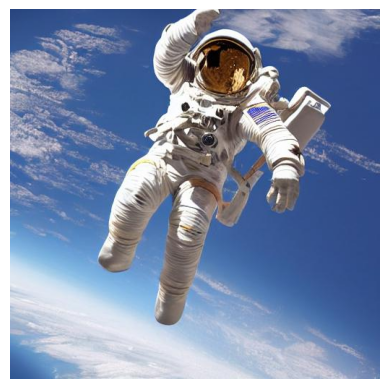

In [ ]:
img_path = '/home/astronaut.jpg'
img = load_img(img_path, 512, 512, return_tensor=True)
show_image(img)

In [ ]:
model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').cuda()
tokenizer = AutoTokenizer.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')

In [ ]:
ddim_scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

#### Step 1 - calculate masks

In the final implementation, need to be able to calculate a mask, or accept a mask tensor. I'm going to use DiffEdit here, but SAM works fine too. The advantage of DiffEdit is that it's usable just by changing the prompt, rather than faffing around with a point.

In [ ]:
edit_text = 'a goat floating above earth'
ref_text = 'an astronaut floating above earth'
diffedit_mask(edit_text, ref_text, img, seed=42, erosion_it=8, dilation_it=14)

NameError: name 'text_encoder' is not defined

#### Step 2 - null text inversion

Handily, we've already done that. Note that in the final implementation, we'll only do null text optimisation in the event that it isn't a generated image — if we're generating the image as well, we'll just use the actual latent intermediates calculated across diffusion steps.

In [ ]:
prompt = 'an astronaut floating in space'
uncond_embeddings = get_embeddings("", text_encoder, tokenizer, concat_unconditional=False, device='cuda')
cond_embeddings = get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=False, device='cuda')

In [ ]:
height, width = 512, 512
latents = encode_img(img_path, height, width, vae) ## start from existing image
steps = 50
device = 'cuda'
ddim_scheduler.set_timesteps(steps)
all_latents = ddim_inversion(latents, cond_embeddings, ddim_scheduler, model)
print("DDIM inversion complete.")

DDIM inversion complete.


In [ ]:
embeddings = torch.cat([cond_embeddings, uncond_embeddings])
z_T, all_null_texts = null_text_inversion(model, ddim_scheduler, all_latents, embeddings, inner_steps=10)
print('Null text inversion complete')

Null text inversion complete


Now we have a trajectory of unconditional embeddings which we can use to reconstruct the original image. Using this, we can run a diffusion loop starting from a random point in latent space and get back the original image.

#### Step 2 - set up attention control

In [ ]:
# set up the custom attn processor and use to replace standard model processors
# note that this is only done for self-attention blocks in the decoder
storage = AttnStorage()
processor = partial(CustomAttnProcessor, storage)
attn_dict = get_attn_dict(processor, model, attention_type='attn1', location='decoder')
model.set_attn_processor(attn_dict)
print("Attention processors set.")

Attention processors set.


In [ ]:
# feature hooks
feat_layers = [1,2]
hooks = [Hook(model.up_blocks[i], get_features) for i in feat_layers]
print('Hooks created.')

Hooks created.


In [ ]:
def dragon_diffusion(
    prompt,
    img_path,
    mask_path,
    model,
    scheduler,
    feat_layers:tuple(int)=(1,2), ## indices of the corresponding up blocks 
    opt_func=partial(optim.Adam, eps=1e-5),
    lr=1e-4, seed=None, steps=50, guidance_scale=5., device='cuda', height=512, width=512, return_original=True
):
    if seed is None: seed = int(torch.rand((1,)) * 1000000)
    
#     # set up the custom attn processor and use to replace standard model processors
#     # note that this is only done for self-attention blocks in the decoder
#     storage = AttnStorage()
#     processor = partial(CustomAttnProcessor, storage)
#     attn_dict = get_attn_dict(processor, model, attention_type='attn1', location='decoder')
#     model.set_attn_processor(attn_dict)
#     print("Attention processors set.")
    
#     # feature hooks
#     hooks = [Hook(model.up_blocks[i], get_features) for i in feat_layers]
    
    # set up embeddings 
    uncond_embeddings = get_embeddings("", concat_unconditional=False, device=device)
    cond_embeddings = get_embeddings(prompt, concat_unconditional=False, device=device)
    print("Embeddings completed.")
    
#     # load masks (different sizes for different feat layers)
#     feat_1_mask = load_mask(mask_path, height//16, width//16)
#     feat_2_mask = load_mask(mask_path, height//8, width//8)
#     masks = (feat_1_mask.to(device), feat_2_mask.to(device))
    
    # DDIM inversion starting from user-provided image
    latents = encode_img(img_path, height, width) ## start from existing image
    ddim_scheduler = DDIMSched(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')
    ddim_scheduler.set_timesteps(steps + 1)
    timesteps = ddim_scheduler.timesteps.flip(0)
    latent_trajectory = torch.zeros(len(ddim_scheduler.timesteps), 4, height//8, width//8)
    with torch.no_grad():
        for i, t in enumerate(progress_bar(timesteps, leave=False, comment="inverting image...")):
            # encode the image into latent space and store the intermediates in latent_trajectory
            latent_trajectory[i] = latents
            latent_model_input = latents.to(device)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            noise_pred = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample
            latents = ddim_scheduler.reverse_step(noise_pred, t, latents).next_sample
            # latents is now the last latent z_T, a noised version of input image
            # the full latent trajectory is now in latent_trajectory in reverse order
            
    for i, image in enumerate(latent_trajectory):
        if i % 10 == 0:
            print(image.shape)
            image = vae.decode(image.to(vae.device).unsqueeze(0)).sample
            show_image(image[0])
    
#     # set up main scheduler, split z_T into two branches
#     ddim_scheduler.set_timesteps(steps)
#     scheduler_2 = copy.deepcopy(scheduler)
#     orig_latents, edit_latents = latents.clone(), latents.clone()
    
#     # set up an optimizer for null text inversion
#     opt_null_text = opt_func([uncond_embeddings], lr)
    
#     print("Latent trajectory completed.")
    
#     # main loop — in this code, "orig"="guidance/gud" and "edit"="generation/gen"
#     for i, t in enumerate(progress_bar(ddim_scheduler.timesteps, leave=False, comment='editing image...')):
        
#         t = t.long()
        
        
#         #### (1) solution path to reconstruct the original image ####
        
#         # uncond_embeddings.requires_grad_(True)
#         # orig_latents.requires_grad_(False)
#         # uncond_embeddings.requires_grad_(True)
#         latent_model_input = scheduler.scale_model_input(orig_latents, t)
    
#         # don't store attention for the uncond prediction
#         # prepare_attention(model, storage, set_store=False, set_inject=False)
#         uncond = model(latent_model_input, t, encoder_hidden_states=uncond_embeddings).sample

#         # do store k/v attention for the cond prediction
#         # prepare_attention(model, storage, set_store=True, set_inject=False)
#         cond = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample
        
#         # get features
#         # f_orig = tuple([h.feats for h in hooks])
        
#         # classifier guidance on the reconstruction path
#         orig_noise_pred = uncond + guidance_scale * (cond - uncond)
#         orig_latents = ddim_scheduler.step(orig_noise_pred, t, orig_latents).prev_sample
        
#         # null text inversion to reconstruct the original image
#         null_text_loss = (orig_latents - latent_trajectory[i].to(device)).mean()
#         null_text_loss.backward()
#         opt_null_text.step()
#         opt_null_text.zero_grad()
        
#         orig_latents = orig_latents.detach()
#         for l in latent_trajectory: l = l.detach()
        
#     orig_latents = 1 / 0.18215 * orig_latents
#     # edit_latents = 1 / 0.18215 * edit_latents

    # with torch.no_grad(): edit_img = vae.decode(edit_latents).sample
    # if not return_original: return edit_img
    # with torch.no_grad(): orig_img = vae.decode(orig_latents).sample
    # return orig_img

Dragon Diffusion class

1. Enable calculation of mask, or accept a custom mask.
2. 